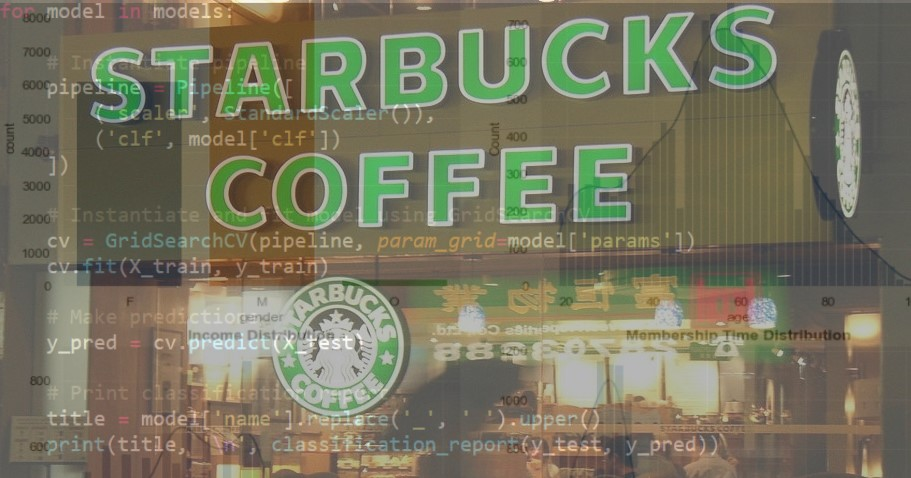
*Picture: Derivative from [DAKALUK](https://commons.wikimedia.org/wiki/File:HK_Starbucks_Coffee_in_Caine_Road.jpg), [CC BY-SA 2.5](https://creativecommons.org/licenses/by-sa/2.5)*

# Predicting Customer Response on Starbucks Promotional Offers  

## Detailed Walk-Through of a Udacity Data Scientist Nanodegree Capstone Project using Supervised Machine Learning with Python, Pandas and Scikit-learn


<a id='contents'></a>
## Table of Contents
**1. <a href='#business_understanding'>Business Understanding</a>**  
  
**2. <a href='#data_understanding'>Data Understanding & Wrangling</a>**  
  
a) <a href='#data_set_structure'>Data Set Structure</a>  
b) <a href='#portfolio'>Investigating *portfolio.json*</a>  
c) <a href='#profile'>Investigating *profile.json*</a>  
d) <a href='#transcript'>Investigating *transcript.json*</a>  
e) <a href='#offer_success'>Accumulationg Success Indicator Data for Offers</a>  
f) <a href='#merge_data'>Merging Offer Data with Demographic Customer and Portfolio Data</a>

**3. <a href='#eda'>Exploratory Data Analysis</a>**  

**4. <a href='#ml'>Building a Machine Learning Model to Predict Offer Success</a>**  

a) <a href='#data_preparation'>Data Preparation</a>  
b) <a href='#modelling'>Modelling</a>  
c) <a href='#model_evaluation'>Evaluation</a>  

**5. <a href='#deployment'>Deployment</a>**  

**6. <a href='#conclusion'>Conclusion</a>**  
  

<a href='#contents'>(Table of Contents)</a>
<a id='business_understanding'></a>
# 1. Business Understanding

The basis of this project is a dataset from a simulated customer test provided by **Starbucks Corporation**, a worldwide coffee chain, that according to [Wikipedia](https://en.wikipedia.org/wiki/Starbucks) as of 2020 operates over 30,000 locations worldwide in more than 70 countries and in 2019 achieved a revenue of $26.5 billion. The data depicts **how customers make purchasing decisions and how these decisions are influenced by promotional offers**. 

During a **30-day test period**, ten **different promotional offers were sent out** to users of the Starbucks rewards programme. The test included three types of offers: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward and no requisite amount the user is expected to spend. The offers were delivered via four different channels: web, email, mobile, social. The test data contains logs of more than **300,000 time-stamped events, including receiving offers, opening offers, completing offers and making purchases**. In addition, there are **demographic data** for the 17,000 participating customers provided.

While the task for this project is not exactly  prescribed, my approach is to use the data to build a supervised machine learning model that  -  based on demographic customer data and offer features  -  predicts customer response on different types of promotional offers.

The project was conducted as part of my [Udacity Data Scientist Nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025).

Due to the use of simulated data, no further regards to data sensisvity and privacy issues were necessary here.

<a href='#contents'>(Table of Contents)</a>
<a id='data_understanding'></a>
# 2. Data Understanding  & Wrangling

<a href='#contents'>(Table of Contents)</a>
<a id='data_set_structure'></a>
## a) Data Set Structure  
The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

**portfolio.json**  
Offers sent during 30-day test period (10 offers x 6 fields).  
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**  
Rewards program users (17000 users x 5 fields).
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**  
Event log (306648 events x 4 fields).  
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

Let's have a closer look at each data set and do some preliminary data cleaning:

In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

%matplotlib inline

In [2]:
# Read in original json files
portfolio_raw = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile_raw = pd.read_json('data/profile.json', orient='records', lines=True)
transcript_raw = pd.read_json('data/transcript.json', orient='records', lines=True)

<a href='#contents'>(Table of Contents)</a>
<a id='portfolio'></a>
## b) Investigating *portfolio.json*

In [3]:
portfolio_raw

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


With only ten rows the data set is pretty overseeable. There are no missing values and the data types fit the values for all columns, so at this stage of the analysis there is not much data cleaning necessary here. However, the **offer ids** are pretty confusing and as there is really no need for these terribly long combinations of characters and digits when there are only ten different offers, I will replace them with some more self-explanatory ids based on the offer type:

In [5]:
# Replace offer ids with
offer_id_dict = {'ae264e3637204a6fb9bb56bc8210ddfd' : 'bogo_1',
                 '4d5c57ea9a6940dd891ad53e9dbe8da0' : 'bogo_2',
                 '3f207df678b143eea3cee63160fa8bed' : 'info_1', 
                 '9b98b8c7a33c4b65b9aebfe6a799e6d9' : 'bogo_3', 
                 '0b1e1539f2cc45b7b9fa7c272da2e1d7' : 'discount_1',
                 '2298d6c36e964ae4a3e7e9706d1fb8c2' : 'discount_2', 
                 'fafdcd668e3743c1bb461111dcafc2a4' : 'discount_3',
                 '5a8bc65990b245e5a138643cd4eb9837' : 'info_2', 
                 'f19421c1d4aa40978ebb69ca19b0e20d' : 'bogo_4', 
                 '2906b810c7d4411798c6938adc9daaa5' : 'discount_4'                
                }

portfolio = portfolio_raw.copy()
portfolio.id = portfolio.id.map(offer_id_dict)

The columns *channels* and *offer_type* both contain categorical variables that I would like to include as input features for my machine learning model later on. To be able to do so, I will convert both columns into multiple columns with **one-hot encodings**.  

In [6]:
# Create one-hot encoding for channels
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
channel_df = pd.DataFrame(mlb.fit_transform(portfolio.channels), columns=['email', 'mobile', 'social', 'web'])

# Add new channel columns to portfolio and drop original column
portfolio = portfolio.join(channel_df).drop(columns='channels')

In [7]:
# Create one-hot encodings for offer_types
offers_df = pd.get_dummies(portfolio.offer_type, drop_first=True)

# Add new channel columns to portfolio (keep original column for easier visualization in EAD)
portfolio = portfolio.join(offers_df)

In [8]:
# Change column order with id first
portfolio = portfolio.reindex(columns=['id', 'offer_type'] + [x for x in portfolio.columns if x not in ['id', 'offer_type']])

In [9]:
portfolio.head()

,id,offer_type,reward,difficulty,duration,email,mobile,social,web,discount,informational
0,bogo_1,bogo,10,10,7,1,1,1,0,0,0
1,bogo_2,bogo,10,10,5,1,1,1,1,0,0
2,info_1,informational,0,0,4,1,1,0,1,0,1
3,bogo_3,bogo,5,5,7,1,1,0,1,0,0
4,discount_1,discount,5,20,10,1,0,0,1,1,0


In [10]:
# Save cleaned data frame as csv
portfolio.to_csv('data/portfolio.csv', index=False)

<a href='#contents'>(Table of Contents)</a>
<a id='profile'></a>
## c) Investigating *profile.json*

In [11]:
profile_raw.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
profile_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
# Check for duplicate customer ids
profile_raw.id.duplicated().sum()

0

In [14]:
# Get number of NaN values for age
(profile_raw.age == 118).sum()

2175

In [15]:
# Check if NaN values for age, gender & income always occur in same rows
profile_raw[(profile_raw.age == 118) & (profile_raw.gender.isnull()) & (profile_raw.income.isnull())]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


Unfortunately, the *profile* data set contains quite a few **missing values**, for *gender*, *age* (encoded as 118) and  *income*. As shown above, these NaN values always occur in the same rows, resulting in 2,175 out of 17,000 customers without any demographic data. As the main target of this project is to build a predictive model based on demographic data, and I can't think of any meaningful method for imputing these data, I will drop these rows, although this means dropping 12.8 percent of the customer data.

In [16]:
# Drop rows for customers without demographic data
profile = profile_raw.dropna(how='all', subset=['gender', 'income']).copy()

# Check for remaining NaN values
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

The date when a customer created an app account is currently encoded in ***became_member_on*** as date with the data type int, which is not optimal. In order to better compare the data and use it as input feature for my ML model, I will convert it into the number of days a customer uses the app. As the exact date for the test not specified, I will define  ***membership_days*** as the timedelta between the actual customer and the date the most recent customer joined.

In [17]:
# Calculated number of membership days defined as described above 
profile['membership_days'] = (pd.to_datetime(str(profile.became_member_on.max()), format='%Y%m%d')
                                  - pd.to_datetime(profile.became_member_on.astype(str), format='%Y%m%d')).dt.days
profile.drop(columns='became_member_on', inplace=True)

To be able to use gender as input feature for the model later on, I will also turn this categorical variable into multiple columns with one-hot encodings (but keep the original column for easier data visualization later on). As every customer's gender is either F, M or O, it is sufficient to use k-1 dummy columns here.

In [18]:
# Create one-hot encodings for gender
gender_cols = pd.get_dummies(profile.gender, prefix='gender', drop_first=True)

# Add new columns to profile data frame
profile = profile.join(gender_cols)

In [19]:
profile.head()

,gender,age,id,income,membership_days,gender_M,gender_O
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0


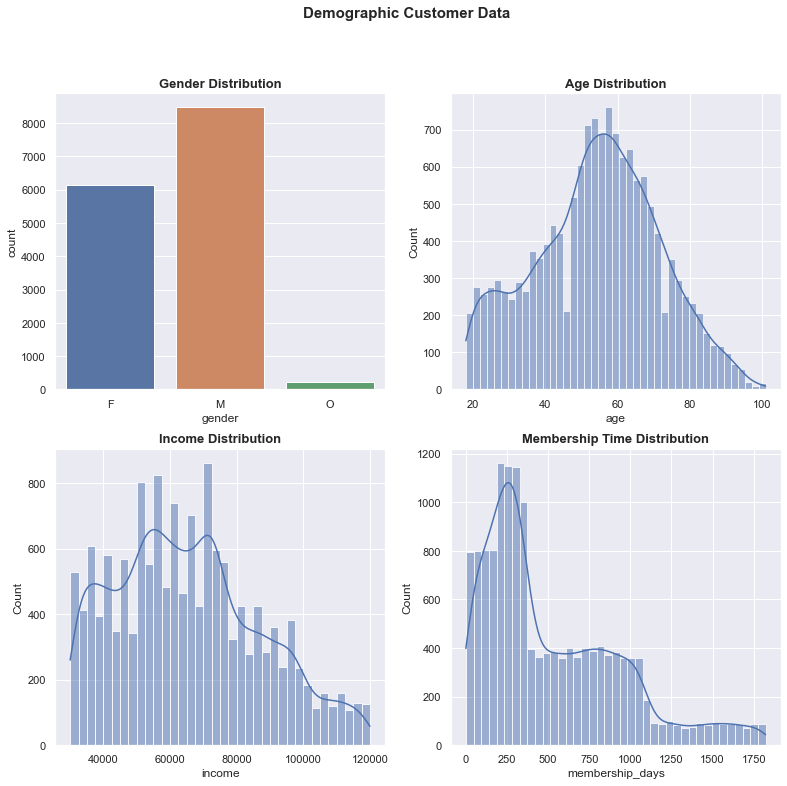

In [20]:
# Visualize distribution of demographic customer data
fig, ax = plt.subplots(2, 2, figsize=(13, 12))
fig.suptitle('Demographic Customer Data', fontsize=15, weight='bold')

# Subplot for gender
plt.subplot(2, 2, 1)
ax = sns.countplot(data=profile, x='gender')
ax.set_title('Gender Distribution', fontsize=13, weight='bold');

# Subplot for age
plt.subplot(2, 2, 2)
ax = sns.histplot(data=profile, x='age', kde=True)
ax.set_title('Age Distribution', fontsize=13, weight='bold');

# Subplot for income
plt.subplot(2, 2, 3)
ax = sns.histplot(data=profile, x='income', kde=True)
ax.set_title('Income Distribution', fontsize=13, weight='bold');

# Subplot for membership time
plt.subplot(2, 2, 4)
ax = sns.histplot(data=profile, x='membership_days', kde=True)
ax.set_title('Membership Time Distribution', fontsize=13, weight='bold');

In [21]:
# Save cleaned data frame as csv
profile.to_csv('data/profile.csv', index=False)

<a href='#contents'>(Table of Contents)</a>
<a id='transcript'></a>
## d) Investigating *transcript.json*

In [22]:
transcript_raw.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [23]:
transcript_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


The data set contains entries for 306.534 events of four different types - with different properties:

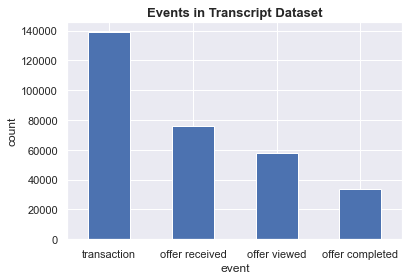

In [24]:
transcript_raw.event.value_counts().plot(kind='bar')
plt.title('Events in Transcript Dataset', fontsize=13, weight='bold')
plt.ylabel('count')
plt.xlabel('event')
plt.xticks(rotation=0);

The features of the events are encoded as dictionaries in the ***value*** column, where the different events have different features:

In [25]:
# Print keys for value column grouped by event
for event_type in transcript_raw.event.unique():
    print(event_type.upper())
    print(transcript_raw[transcript_raw.event == event_type].value.apply(lambda val: val.keys()
                                                                        ).explode().value_counts(),'\n')

OFFER RECEIVED
offer id    76277
Name: value, dtype: int64 

OFFER VIEWED
offer id    57725
Name: value, dtype: int64 

TRANSACTION
amount    138953
Name: value, dtype: int64 

OFFER COMPLETED
offer_id    33579
reward      33579
Name: value, dtype: int64 



To make it easier to access these event properties I will pull them into separate columns and drop the original *value* column (although this will inevitably create some NaN values, which shouldn't be a problem here). 

In [26]:
# Transform dict values from value column into own columns
def get_value(val_dict, key):
    if key in val_dict:
        return val_dict[key]
    elif key.replace('_', ' ') in val_dict:
        return val_dict[key.replace('_', ' ')]
    
for key in ['offer_id', 'amount', 'reward']:
    transcript_raw[key] = transcript_raw.value.apply(get_value, key=key)
    
transcript = transcript_raw.drop(columns='value').copy()

In [27]:
# Replace offer id values with easier to understand ids from profile data frame
transcript['offer_id'] = transcript.offer_id.map(offer_id_dict)

In [28]:
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,bogo_3,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,discount_1,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,discount_4,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,discount_3,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,bogo_2,NaN,NaN


In [29]:
transcript.describe()

,time,amount,reward
count,306534.000000,138953.000000,33579.000000
mean,366.382940,12.777356,4.904137
std,200.326314,30.250529,2.886647
min,0.000000,0.050000,2.000000
25%,186.000000,2.780000,2.000000
50%,408.000000,8.890000,5.000000
75%,528.000000,18.070000,5.000000
max,714.000000,1062.280000,10.000000


In [30]:
# Save cleaned data frame as csv
transcript.to_csv('data/transcript.csv', index=False)

<a href='#contents'>(Table of Contents)</a>
<a id='offer_success'></a>
## f) Accumulationg Success Indicator Data for Offers

In [31]:
# Read cleaned data frames from csv files
portfolio = pd.read_csv('data/portfolio.csv')
profile = pd.read_csv('data/profile.csv')
transcript = pd.read_csv('data/transcript.csv')

As the main focus of the project is to find out what happened with each offer, the structure of the *transcript* with rows for all four event types is not optimal for this purpose. To make it easier to navigate the data I will create a new data frame ***offers*** that contains only the rows for received offers, and subsequently add further data for these offers. The main goal of this step is to define a success indicator for each individual opromotional offer that can be used as target label for the machine leraning model later on.

In [32]:
offers = transcript[transcript.event == 'offer received'].drop(
    columns = ['event', 'amount', 'reward']).reset_index(drop=True)
offers.head()

,person,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,bogo_3
1,a03223e636434f42ac4c3df47e8bac43,0,discount_1
2,e2127556f4f64592b11af22de27a7932,0,discount_4
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,discount_3
4,68617ca6246f4fbc85e91a2a49552598,0,bogo_2


Let's now have a closer look at the ***time*** column to find out how the different offers were distributed throughout the experiment:

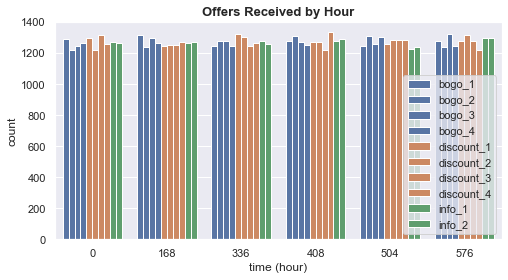

In [33]:
c = sns.color_palette()
cols = 4*[c[0]] + 4*[c[1]] + 2*[c[2]]
plt.figure(figsize=(8,4))
sns.countplot(data=offers.sort_values('offer_id'), x='time', hue='offer_id', palette=cols)
plt.title('Offers Received by Hour', fontsize=13, weight='bold')
plt.legend(loc=4)
plt.xlabel('time (hour)');

This reveals two important insights on the structure of the experiment:  

1. All the offers were sent out on only six distinct points in time during the test phase.  
2. At each of these points in time, a roughly eqal number of all ten different offers was distributed.  

The next question is if every customer has received the same number of offers?

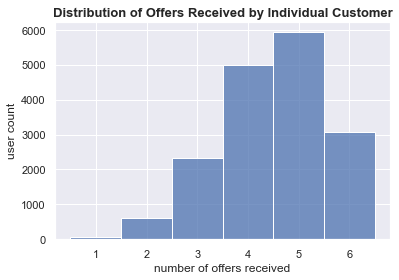

In [34]:
# Visualize distribution of number of offers received by customer
sns.histplot(offers.groupby('person').offer_id.count(), discrete=True)
plt.title('Distribution of Offers Received by Individual Customer', fontsize=13, weight='bold')
plt.xlabel('number of offers received')
plt.ylabel('user count');

In [35]:
# Get maximum number of same offers received by a single customer
offers.groupby('person').offer_id.value_counts().max()

5

In [36]:
# Get maximum number of offers a single user received at one moment in time
offers.groupby(['person', 'time']).offer_id.count().max()

1

This is obviously not the case. Just from the short snippet above we can conclude that: 

3. The number of offers each customer received varies.  
4. Some customers did receive the same offer multiple times.  
  
By now the new data frame does not contain any **information whether an offer was successful** or not, so the next step will be to add these data. 

This is not so easy to determine as it seems. The first idea would be to simply look for *offer completed* events from the *transcript* data frame. As there is no unique id for the individual offer itself (*offer_id* refers only to the type of offer) and the same offer type might be sent out multiple times to one and the same customer, I will only include *offer completed* events of the same type (= *offer_id* ) that were sent out to the same *customer_id* within the *duration* period of this certain offer type after the offer was received.  

Furthermore, an *offer completed* event is registered whenever a customer makes purchases of at least the difficulty of that certain offer type - no matter if they have ever viewed the offer. In contrast, we are interested in customers whose purchase was induced by the offer. And while it is impossible to definitively determine if a purchase was really a consequence of the offer or if the customer would have made the purchase anyway, we can for sure say that the purchase was not caused by the offer if the customer did not view the offer before.

To determine whether an offer was succesful or not, I will therefore pull both the view time and completion time for every offer and add them as new columns to the *offer* data frame (whenever there are such events within the duration of the offer) and then define an offer as succesful when it was both completed and the offer was viewed *before* completion.

In [37]:
def get_event_time(row, event='offer viewed', portfolio=portfolio, transcript=transcript):
    '''
    Takes a row from the offers data frame and returns the event time of a certain event, if there is 
    such an event within the offer's duration, else np.nan.
    
    INPUT:
    row (pandas series) : row from offers data frame as defined above, including offer_id and 
                            user_idID of a customer contained in the portfolio data frame
    event (str) : 'offer viewed', 'offer completed'
    portfolio (data frame) : promotional offer portfolio as defined above
    transcript (data frame) : event data as defined above
    
    OUTPUT:
    event_time (float): time of given event for given user within offer duration, else np.nan
    '''
    
    # Get duration of current offer and turn from days into hours
    duration = portfolio[portfolio.id == row.offer_id].duration.values[0] * 24
    # Calculate time offer expires
    expiry_time = row.time + duration
    # Check if offer_id for this customer was viewed within duration and if so return view time
    try:
        event_time = transcript[(transcript.time >= row.time) & (transcript.time <= expiry_time) 
                                & (transcript.event == event) & (transcript.person == row.person) 
                                & (transcript.offer_id == row.offer_id)].time.values[0]
    except:
        event_time = np.nan
    return event_time

In [38]:
# Add new columns with times when offer was viewed and completed
offers['time_viewed'] = offers.apply(get_event_time, event='offer viewed', axis=1)
offers['time_completed'] = offers.apply(get_event_time, event='offer completed', axis=1)

Applying the function to all 76,000+ rows will take some time but is worth the effort, as we now have all the relevant information on each offer in one single row in the *offer* data frame and can easily determine whether the offer was a real success.   

To complete the data frame I will further add one row with information whether we have demographic data on the customer receiving the offer, as only these rows can be used for training a machine learning model that is based on demographic customer data.

In [39]:
# Add column with info if offer was succesful
offers['success'] = ((offers.time_completed.notnull()) & (offers.time_viewed <= offers.time_completed)
                    ).astype(int)

In [40]:
# Add new colum with info whether demographic data is available (= 1) or not (= 0)
ids_with_demographics = list(profile.id)
offers['demographic_data'] = offers.person.isin(ids_with_demographics).astype(int)

In [41]:
offers.head()

,person,time,offer_id,time_viewed,time_completed,success,demographic_data
0,78afa995795e4d85b5d9ceeca43f5fef,0,bogo_3,6.0,132.0,1,1
1,a03223e636434f42ac4c3df47e8bac43,0,discount_1,6.0,NaN,0,0
2,e2127556f4f64592b11af22de27a7932,0,discount_4,18.0,NaN,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,discount_3,12.0,NaN,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,bogo_2,84.0,NaN,0,0


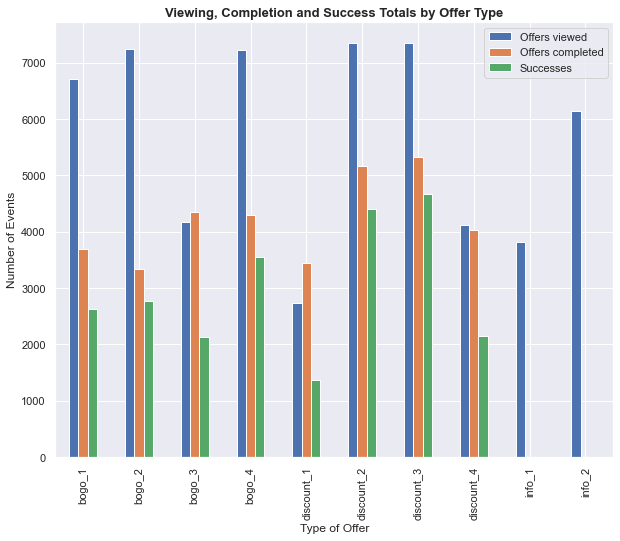

In [42]:
# Visualize Viewing, Completion and Success Totals by Offer Type
offers.groupby('offer_id').agg({'time_viewed': ['count'], 'time_completed': ['count'], 'success' : ['sum']}).plot(
    kind='bar', figsize=(10, 8))
plt.title('Viewing, Completion and Success Totals by Offer Type', fontsize=13, weight='bold')
plt.legend(['Offers viewed', 'Offers completed', 'Successes'])
plt.ylabel('Number of Events')
plt.xlabel('Type of Offer');

The visualization of the number of success events reveals one major flaw in my method: As success was defined based on offer completion and there was no offer completion checked in for info offers, all these offers are currently labeled as not succesful. 

However, we should label informational offers as success if any purchase was made within the duration of these offers, after the customers viewed the offers. Therefore we have to reevaluate oll info offers that have been viewed within the duration period and check for anay transactions:

In [43]:
def update_success_for_information_offers(row, portfolio=portfolio, transcript=transcript):
    '''
    Takes a row from the offers data frame and checks if any transaction has been logged for 
    the given usersid within the duration of this offer.
    
    INPUT:
    row (pandas series) : row from offers data frame as defined above, including offer_id and 
                            user_id of a customer contained in the portfolio data frame
    portfolio (data frame) : promotional offer portfolio as defined above
    transcript (data frame) : event data as defined above
    
    OUTPUT:
    (int): 1 if there was any transaction, else 0
    '''
    # Get duration of current offer
    duration = portfolio[portfolio.id == row.offer_id].duration.values[0] * 24
    # Calculate time offer expires
    expiry_time = row.time + duration
    # Check if there were any transactions between offer was viewed and offer duration ended
    if len(transcript[(transcript.event == 'transaction') & (transcript.person == row.person) 
                      & (transcript.time >= row.time) & (transcript.time <= expiry_time)]) > 0:
        return 1
    return 0

In [44]:
# Get subset of info offers with need for reevaluation
mask = (offers.offer_id.isin(['info_1', 'info_2']) & offers.time_viewed.notnull())

# Update success values for subset as described above
offers.loc[mask, 'success'] = offers[mask].apply(update_success_for_information_offers, axis=1)

Plotting the same visualization again shows that we by this method were able to generate some reasonable succes data also for the info offers:

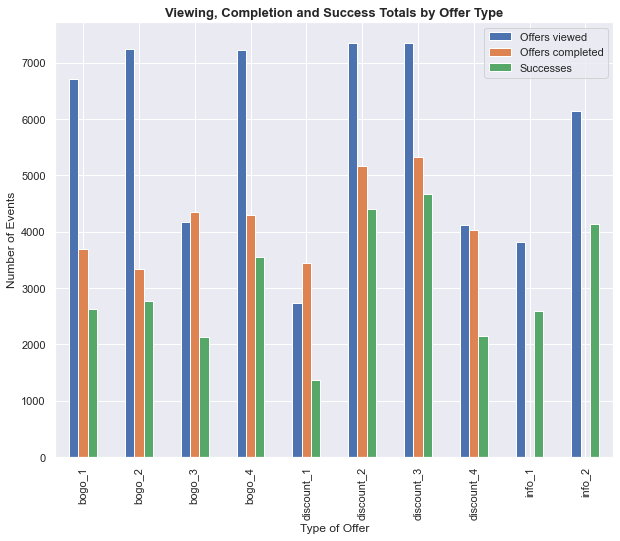

In [45]:
# Visualize Viewing, Completion and Success Totals by Offer Type
offers.groupby('offer_id').agg({'time_viewed': ['count'], 'time_completed': ['count'], 'success' : ['sum']}).plot(
    kind='bar', figsize=(10, 8))
plt.title('Viewing, Completion and Success Totals by Offer Type', fontsize=13, weight='bold')
plt.legend(['Offers viewed', 'Offers completed', 'Successes'])
plt.ylabel('Number of Events')
plt.xlabel('Type of Offer');

In [46]:
offers.head()

,person,time,offer_id,time_viewed,time_completed,success,demographic_data
0,78afa995795e4d85b5d9ceeca43f5fef,0,bogo_3,6.0,132.0,1,1
1,a03223e636434f42ac4c3df47e8bac43,0,discount_1,6.0,NaN,0,0
2,e2127556f4f64592b11af22de27a7932,0,discount_4,18.0,NaN,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,discount_3,12.0,NaN,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,bogo_2,84.0,NaN,0,0


In [47]:
# Save augmented offer data frame as csv file
offers.to_csv('data/offers.csv', index=False)

<a href='#contents'>(Table of Contents)</a>
<a id='merge_data'></a>
## f) Merging Offer Data with Demographic Customer and Portfolio Data  

In [48]:
# Read data frames from csv files
portfolio = pd.read_csv('data/portfolio.csv')
profile = pd.read_csv('data/profile.csv')
transcript = pd.read_csv('data/transcript.csv')
offers = pd.read_csv('data/offers.csv')

In [49]:
# Merge offers with demographic customer data
offers_complete = offers[offers.demographic_data == 1].merge(profile, how='left', left_on='person', right_on='id'
                                          ).drop(columns=['demographic_data', 'id', 'time_viewed', 'time_completed'])

# Merge offers with portfolio data
offers_complete = offers_complete.merge(portfolio, how='left', left_on='offer_id', right_on='id').drop(columns='id')

In [50]:
offers_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 66500
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   person           66501 non-null  object 
 1   time             66501 non-null  int64  
 2   offer_id         66501 non-null  object 
 3   success          66501 non-null  int64  
 4   gender           66501 non-null  object 
 5   age              66501 non-null  int64  
 6   income           66501 non-null  float64
 7   membership_days  66501 non-null  int64  
 8   gender_M         66501 non-null  int64  
 9   gender_O         66501 non-null  int64  
 10  offer_type       66501 non-null  object 
 11  reward           66501 non-null  int64  
 12  difficulty       66501 non-null  int64  
 13  duration         66501 non-null  int64  
 14  email            66501 non-null  int64  
 15  mobile           66501 non-null  int64  
 16  social           66501 non-null  int64  
 17  web         

The resulting data frame contains all data needed for building my model. It still contains some columns that I don't intend to use for the model, like *time_viewed* or *time_completed* and some redundant columns, like *gender* (as the same information is encoded in 'gender_M' and 'gender_O'). The reason for not dropping these columns yet is that they still might be useful for easier visualizations in the following exploratory data analysis.  

There are also two columns with NaN values, *time_viewed* or *time_completed*, which will not be used for the  model, so there is no need for further steps here. 

In [51]:
offers_complete.head()

,person,time,offer_id,success,gender,age,income,membership_days,gender_M,gender_O,offer_type,reward,difficulty,duration,email,mobile,social,web,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,bogo_3,1,F,75,100000.0,443,0,0,bogo,5,5,7,1,1,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,0,discount_4,0,M,68,70000.0,91,1,0,discount,2,10,7,1,1,0,1,1,0
2,389bc3fa690240e798340f5a15918d5c,0,bogo_4,1,M,65,53000.0,167,1,0,bogo,5,5,5,1,1,1,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,info_1,0,M,58,51000.0,257,1,0,informational,0,0,4,1,1,0,1,0,1
4,aa4862eba776480b8bb9c68455b8c2e1,0,discount_1,0,F,61,57000.0,318,0,0,discount,5,20,10,1,0,0,1,1,0


One interesting question is to what extend dropping offer records without demographic data has changed the overall success rate. The overall success rate as indeed climbed from 39.86 % to 43.02 % (caused by a very low succes rate for customers without demographic data). With this success rate, I would consider the data set quite balanced. Therefore, I have decided not to use any methods to further balance the data before fitting the ML model later on (like undersampling, oversampling or SMOTE), as also each of these methods has a pay-off.

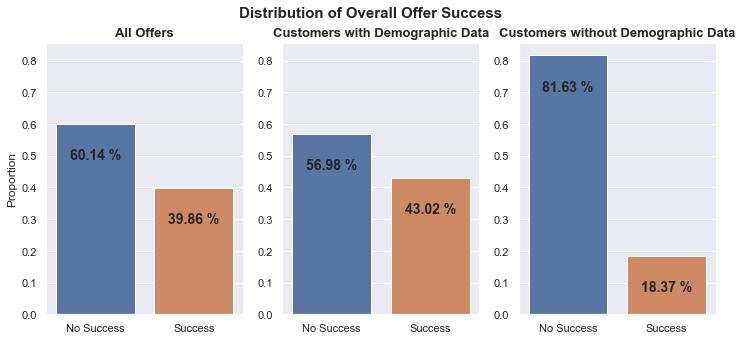

In [52]:
# Visualize success probabilities
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Distribution of Overall Offer Success', fontsize=15, weight='bold')

# Subplot for all offers
plt.subplot(1, 3, 1)
success = offers.success.value_counts(normalize=True)
ax1 = sns.barplot(x=success.index, y=success)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height() *100:.2f} %' , (p.get_x() + p.get_width() / 2., p.get_height()-0.1),
             ha='center', va='center', fontsize=14, weight='bold')  
ax1.set_title('All Offers', fontsize=13, weight='bold')
ax1.set_ylabel('Proportion')
ax1.set_xticklabels(['No Success', 'Success']);

# Subplot for only offers with demographic data avaliable
plt.subplot(1, 3, 2, sharey=ax1)
success_dem = offers_complete.success.value_counts(normalize=True)
ax2 = sns.barplot(x=success_dem.index, y=success_dem)
for p in ax2.patches:
    ax2.annotate(f'{p.get_height() *100:.2f} %' , (p.get_x() + p.get_width() / 2., p.get_height()-0.1),
             ha='center', va='center', fontsize=14, weight='bold')  
ax2.set_title('Customers with Demographic Data', fontsize=13, weight='bold')
ax2.set_ylabel('')
ax2.set_xticklabels(['No Success', 'Success']);

# Subplot for only offers without demographic data avaliable
plt.subplot(1, 3, 3, sharey=ax1)
success_dem = offers[offers.demographic_data == 0].success.value_counts(normalize=True)
ax3 = sns.barplot(x=success_dem.index, y=success_dem)
for p in ax3.patches:
    ax3.annotate(f'{p.get_height() *100:.2f} %' , (p.get_x() + p.get_width() / 2., p.get_height()-0.1),
             ha='center', va='center', fontsize=14, weight='bold')  
ax3.set_title('Customers without Demographic Data', fontsize=13, weight='bold')
ax3.set_ylabel('')
ax3.set_xticklabels(['No Success', 'Success']);

In [53]:
# Save accumulated data to csv
offers_complete.to_csv('data/offers_complete.csv', index=False)

<a href='#contents'>(Table of Contents)</a>
<a id='eda'></a>
# 3. Exploratory Data Analysis  

Before starting the actual modelling, it's worth plotting a few data visualizations to further scrutinize the correlations between certain features - both demographic customer features and offer features - and promotional offer success.

In [54]:
# Read data from csv file
df = pd.read_csv('data/offers_complete.csv')
df.head()

,person,time,offer_id,success,gender,age,income,membership_days,gender_M,gender_O,offer_type,reward,difficulty,duration,email,mobile,social,web,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,bogo_3,1,F,75,100000.0,443,0,0,bogo,5,5,7,1,1,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,0,discount_4,0,M,68,70000.0,91,1,0,discount,2,10,7,1,1,0,1,1,0
2,389bc3fa690240e798340f5a15918d5c,0,bogo_4,1,M,65,53000.0,167,1,0,bogo,5,5,5,1,1,1,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,info_1,0,M,58,51000.0,257,1,0,informational,0,0,4,1,1,0,1,0,1
4,aa4862eba776480b8bb9c68455b8c2e1,0,discount_1,0,F,61,57000.0,318,0,0,discount,5,20,10,1,0,0,1,1,0


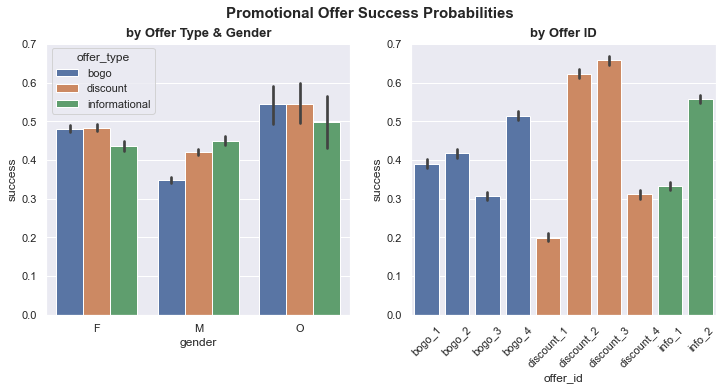

In [55]:
# Visualize success probabilities
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Promotional Offer Success Probabilities', fontsize=15, weight='bold')

# Subplot for offer type & gender
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=df, x='gender', y='success', hue='offer_type')
ax1.set_title('by Offer Type & Gender', fontsize=13, weight='bold');

# Subplot for offer ID
c = sns.color_palette()
cols = 4*[c[0]] + 4*[c[1]] + 2*[c[2]]
plt.subplot(1, 2, 2, sharey=ax1)
ax2 = sns.barplot(data=df.sort_values('offer_id'), x='offer_id', y='success', palette=cols)
ax2.set_title('by Offer ID', fontsize=13, weight='bold')
plt.xticks(rotation=45);

There are quite a lot of interesting insights to draw from these visualizations, e.g. on the correlation between **offer type, gender and success**. For some reasons, BOGO offers seem to be lesss attractive for male Starbucks customers. It's also striking how **success rates differ within the same offer type** (e.g. between discount_1 and discount_2), which might be caused by other offer features like channel, difficulty, duration, or reward. In addition, it's worth having a closer look at the **influence of membership time and income level** on offer success.  

As the main focus of this project is on building a predictive model, I will not comment the results in detail here, but rather let the data speak for itself and leave it up to you to draw further conclusions:

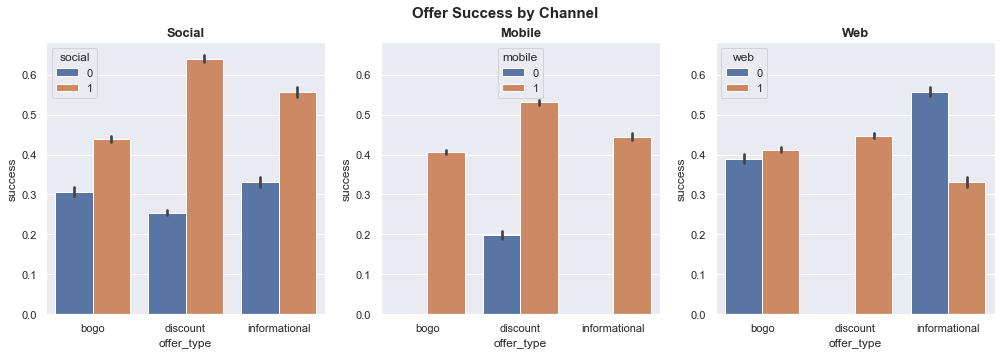

In [56]:
# Visualize success probability grouped by channel
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle('Offer Success by Channel', fontsize=15, weight='bold')

# Subplot for social
plt.subplot(1, 3, 1)
ax1 = sns.barplot(data=df, x='offer_type', y='success', hue='social')
ax1.set_title('Social', fontsize=13, weight='bold');

# Subplot for mobile
plt.subplot(1, 3, 2, sharey=ax1)
ax2 = sns.barplot(data=df, x='offer_type', y='success', hue='mobile')
ax2.set_title('Mobile', fontsize=13, weight='bold');

# Subplot for web
plt.subplot(1, 3, 3, sharey=ax1)
ax3 = sns.barplot(data=df, x='offer_type', y='success', hue='web')
ax3.set_title('Web', fontsize=13, weight='bold');

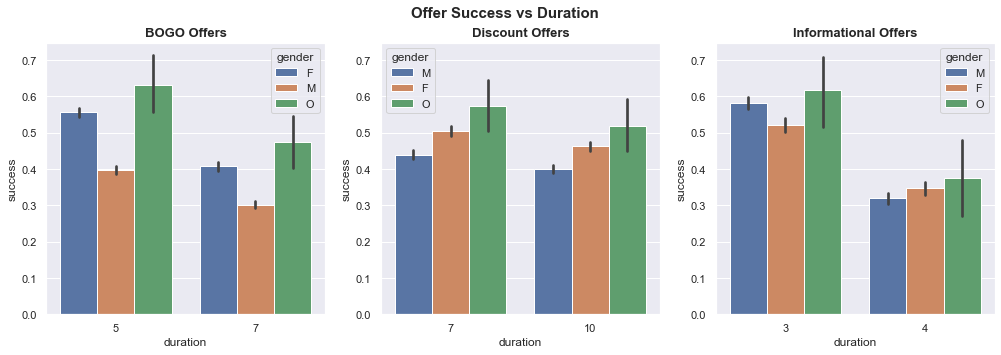

In [57]:
# Visualize success probability grouped by duration
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle('Offer Success vs Duration', fontsize=15, weight='bold')

# Subplot for bogo offers
plt.subplot(1, 3, 1)
ax1 = sns.barplot(data=df[df.offer_type == 'bogo'], x='duration', y='success', hue='gender')
ax1.set_title('BOGO Offers', fontsize=13, weight='bold');

# Subplot for discount offers
plt.subplot(1, 3, 2, sharey=ax1)
ax2 = sns.barplot(data=df[df.offer_type == 'discount'], x='duration', y='success', hue='gender')
ax2.set_title('Discount Offers', fontsize=13, weight='bold');

# Subplot for informational offers
plt.subplot(1, 3, 3, sharey=ax1)
ax3 = sns.barplot(data=df[df.offer_type == 'informational'], x='duration', y='success', hue='gender')
ax3.set_title('Informational Offers', fontsize=13, weight='bold');

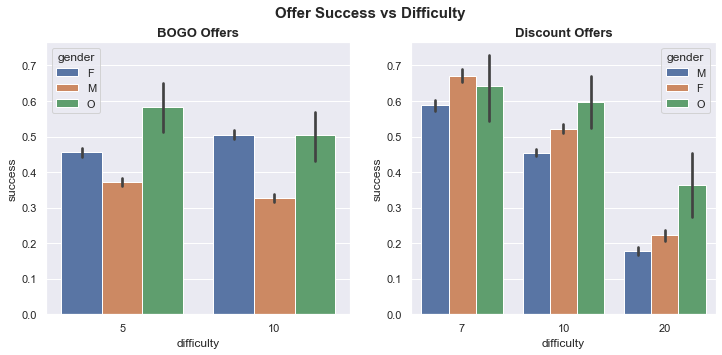

In [58]:
# Visualize success probability grouped by difficulty
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Offer Success vs Difficulty', fontsize=15, weight='bold')

# Subplot for bogo offers
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=df[df.offer_type == 'bogo'], x='difficulty', y='success', hue='gender')
ax1.set_title('BOGO Offers', fontsize=13, weight='bold');

# Subplot for discount offers
plt.subplot(1, 2, 2, sharey=ax1)
ax2 = sns.barplot(data=df[df.offer_type == 'discount'], x='difficulty', y='success', hue='gender')
ax2.set_title('Discount Offers', fontsize=13, weight='bold');

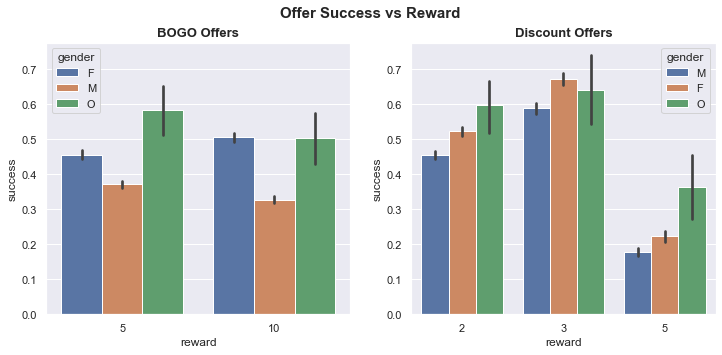

In [59]:
# Visualize success probability grouped by reward
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Offer Success vs Reward', fontsize=15, weight='bold')

# Subplot for bogo offers
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=df[df.offer_type == 'bogo'], x='reward', y='success', hue='gender')
ax1.set_title('BOGO Offers', fontsize=13, weight='bold');

# Subplot for discount offers
plt.subplot(1, 2, 2, sharey=ax1)
ax2 = sns.barplot(data=df[df.offer_type == 'discount'], x='reward', y='success', hue='gender')
ax2.set_title('Discount Offers', fontsize=13, weight='bold');

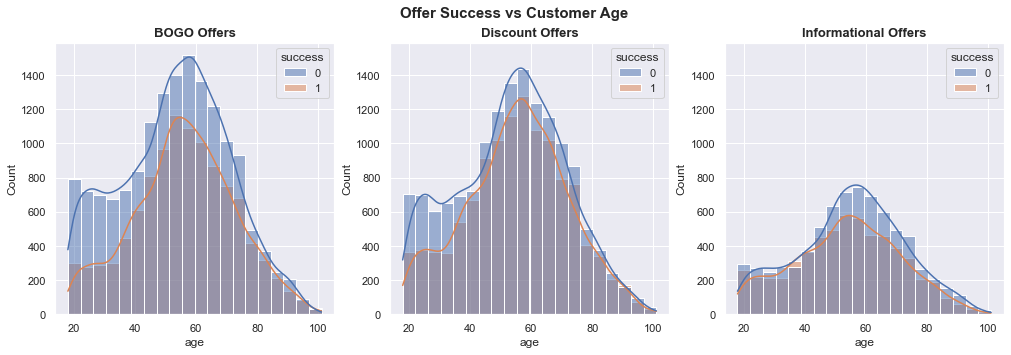

In [60]:
# Visualize distribution of customer age grouped by success
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle('Offer Success vs Customer Age', fontsize=15, weight='bold')

# Subplot for bogo offers
plt.subplot(1, 3, 1)
ax1 = sns.histplot(data=df[df.offer_type == 'bogo'], x='age', kde=True, bins=20, hue='success')
ax1.set_title('BOGO Offers', fontsize=13, weight='bold');

# Subplot for discount offers
plt.subplot(1, 3, 2, sharey=ax1)
ax2 = sns.histplot(data=df[df.offer_type == 'discount'], x='age', kde=True, bins=20, hue='success')
ax2.set_title('Discount Offers', fontsize=13, weight='bold');

# Subplot for informational offers
plt.subplot(1, 3, 3, sharey=ax1)
ax3 = sns.histplot(data=df[df.offer_type == 'informational'], x='age', kde=True, bins=20, hue='success')
ax3.set_title('Informational Offers', fontsize=13, weight='bold');

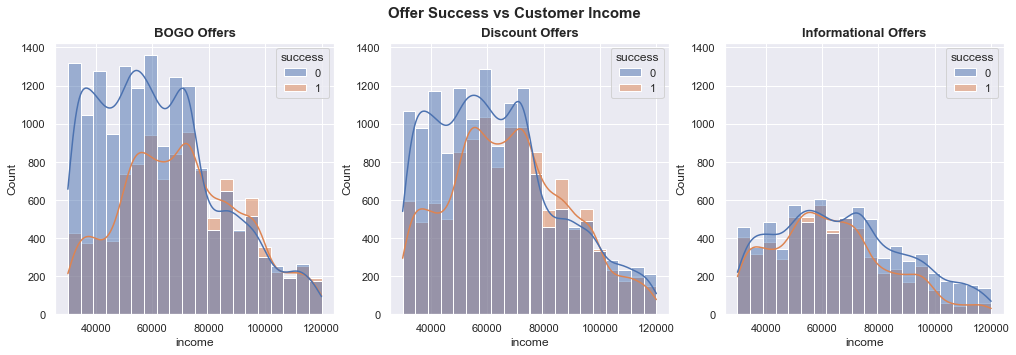

In [61]:
# Visualize distribution of customer age grouped by success
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle('Offer Success vs Customer Income', fontsize=15, weight='bold')

# Subplot for bogo offers
plt.subplot(1, 3, 1)
ax1 = sns.histplot(data=df[df.offer_type == 'bogo'], x='income', kde=True, bins=20, hue='success')
ax1.set_title('BOGO Offers', fontsize=13, weight='bold');

# Subplot for discount offers
plt.subplot(1, 3, 2, sharey=ax1)
ax2 = sns.histplot(data=df[df.offer_type == 'discount'], x='income', kde=True, bins=20, hue='success')
ax2.set_title('Discount Offers', fontsize=13, weight='bold');

# Subplot for informational offers
plt.subplot(1, 3, 3, sharey=ax1)
ax3 = sns.histplot(data=df[df.offer_type == 'informational'], x='income', kde=True, bins=20, hue='success')
ax3.set_title('Informational Offers', fontsize=13, weight='bold');

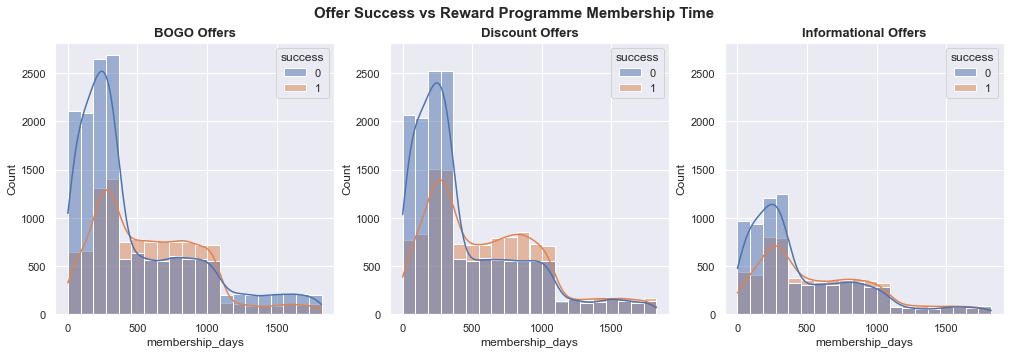

In [62]:
# Visualize distribution of membership days grouped by success
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle('Offer Success vs Reward Programme Membership Time', fontsize=15, weight='bold')

# Subplot for bogo offers
plt.subplot(1, 3, 1)
ax1 = sns.histplot(data=df[df.offer_type == 'bogo'], x='membership_days', kde=True, bins=20, hue='success')
ax1.set_title('BOGO Offers', fontsize=13, weight='bold');

# Subplot for discount offers
plt.subplot(1, 3, 2, sharey=ax1)
ax2 = sns.histplot(data=df[df.offer_type == 'discount'], x='membership_days', kde=True, bins=20, hue='success')
ax2.set_title('Discount Offers', fontsize=13, weight='bold');

# Subplot for informational offers
plt.subplot(1, 3, 3, sharey=ax1)
ax3 = sns.histplot(data=df[df.offer_type == 'informational'], x='membership_days', kde=True, bins=20, hue='success')
ax3.set_title('Informational Offers', fontsize=13, weight='bold');

<a href='#contents'>(Table of Contents)</a>
<a id='ml'></a>
# 4. Building a Machine Learning Model to Predict Offer Success

<a href='#contents'>(Table of Contents)</a>
<a id='data_preparation'></a>
## a) Data Preparation  

Before staring the model building, it's time for some final data preparation by **dropping redundant columns**, resulting in a data frame df with one target label (success) and 14 numerical input features for the model. For model training and evaluation, the data frame is first converted into two different numpy arrays for **input features (X)** and **target labels (y)** and then split into **training data (70%)** and **testing data (30%)**:

In [76]:
# Read data from csv file
df = pd.read_csv('data/offers_complete.csv')
df.head()

,person,time,offer_id,success,gender,age,income,membership_days,gender_M,gender_O,offer_type,reward,difficulty,duration,email,mobile,social,web,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,bogo_3,1,F,75,100000.0,443,0,0,bogo,5,5,7,1,1,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,0,discount_4,0,M,68,70000.0,91,1,0,discount,2,10,7,1,1,0,1,1,0
2,389bc3fa690240e798340f5a15918d5c,0,bogo_4,1,M,65,53000.0,167,1,0,bogo,5,5,5,1,1,1,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,info_1,0,M,58,51000.0,257,1,0,informational,0,0,4,1,1,0,1,0,1
4,aa4862eba776480b8bb9c68455b8c2e1,0,discount_1,0,F,61,57000.0,318,0,0,discount,5,20,10,1,0,0,1,1,0


In [77]:
df.drop(columns=['person', 'time', 'offer_id', 'gender', 'offer_type'], inplace=True)

In [78]:
df.head()

,success,age,income,membership_days,gender_M,gender_O,reward,difficulty,duration,email,mobile,social,web,discount,informational
0,1,75,100000.0,443,0,0,5,5,7,1,1,0,1,0,0
1,0,68,70000.0,91,1,0,2,10,7,1,1,0,1,1,0
2,1,65,53000.0,167,1,0,5,5,5,1,1,1,1,0,0
3,0,58,51000.0,257,1,0,0,0,4,1,1,0,1,0,1
4,0,61,57000.0,318,0,0,5,20,10,1,0,0,1,1,0


In [79]:
# Define X and y
X = np.array(df.iloc[:, 1:])
y = np.array(df.success)

# Check shape
X.shape, y.shape

((66501, 14), (66501,))

In [80]:
from sklearn.model_selection import train_test_split

# Split data into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((46550, 14), (19951, 14), (46550,), (19951,))

<a href='#contents'>(Table of Contents)</a>
<a id='modelling'></a>
## b) Modelling  

The next decision to make is the **selection of a machine learning algorithm**. Predicting offer success as defined above is a typical **supervised classification task**, providing a wide choice of different algorithms available in Scikit-learn. I will try out several of them to compare there performance on the given data, but first we should keep in mind one important thing regarding the real-world application of our model.  

Predicting customer response on promotional offers based on demographic data with absolute certainty is impossible, of course, simply because in real life even one and the same customer will react differently to one and the same offer on different occasions (depending on several factors like e.g. weather, mood, current location). So for a real-world application, it would be much better to predict the probabilities of successful offer responses rather than just predicting a success or not. Therefore, I will not use any classification algorithms that do not (directly) support probability estimation, like e.g. Support Vector Machines.

Based on these considerations, I have choosen **six different ML algorithms** for performance comparison:  
1. Decision Trees  
2. Logistic Regression  
3. Nearest Neighbours (KNN)  
4. Naive Bayes  
5. Random Forest  
6. Gradient Boosting

For  optimizing the hyper parameters of the model, I will use **GridSearchCV**, which runs cross validation on all  different combinations of a given parameter grid. GridSearchCV is used in combination with **Pipeline** to standardize the input data by running a StandardScaler only on the training data set within each fold of the cross validation. This is important, as first standardizing the whole training data set and then using cross validation in grid search would cause data leakage.

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

In [82]:
# Define parameter grids for different classification algorithms
models = [{'name': 'decision_tree',
           'clf' : DecisionTreeClassifier(),
           'params' : {'clf__criterion' : ['gini', 'entropy'],
                       'clf__splitter' : ['best', 'random'],
                       'clf__max_depth' : [6, None],
                       'clf__min_samples_split' : [2, 4],
                       'clf__min_impurity_decrease' : [0.0, 0.1]
                      }
          },
          {'name': 'logistic_regression',
           'clf' : LogisticRegression(),
           'params' : {'clf__C' : [0.01, 0.1, 1.0, 2.0],
                       'clf__solver' : ['liblinear', 'lbfgs', 'saga', 'newton-cg']
                      }
          },
          {'name': 'knn',
           'clf' : KNeighborsClassifier(),
           'params' : {'clf__n_neighbors' : [3, 5, 7],
                       'clf__weights' : ['uniform', 'distance'],
                       'clf__p' : [1, 2]
                      }
          },
          {'name': 'naive_bayes',
           'clf' : GaussianNB(),
           'params' : {'clf__var_smoothing' : [1e-10, 1e-9, 1e-8]}
          },
          {'name': 'random_forest',
           'clf' : RandomForestClassifier(),
           'params' : {'clf__criterion' : ['gini', 'entropy'],
                       'clf__n_estimators' : [50, 100],
                       'clf__max_depth' : [6, None],
                       'clf__min_samples_split' : [2, 4]
                      }
          },
           {'name': 'gradient_boosting',
           'clf' : GradientBoostingClassifier(),
           'params' : {'clf__loss' : ['deviance', 'exponential'],
                       'clf__n_estimators' : [100, 200],
                       'clf__min_samples_split' : [2, 4]
                      }
           }
         ]

In [83]:
# Implement different classification algorithms as described above
accuracy_scores = {}
for model in models:
    
    # Instantiate pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model['clf'])
    ])
    
    # Instantiate and fit model using GridSearchCV
    cv = GridSearchCV(pipeline, param_grid=model['params'])
    cv.fit(X_train, y_train)
    
    # Make predictions
    y_pred = cv.predict(X_test)
    
    # Print classification report
    title = model['name'].replace('_', ' ').upper()
    print(title, '\n', classification_report(y_test, y_pred))
        
    # Save accuracy score
    accuracy_scores[title] = accuracy_score(y_test, y_pred)
    
    # Save model as pkl file
    filepath = f'data/{model["name"]}.pkl'
    with open(filepath, 'wb') as file:
        pickle.dump(cv, file)

DECISION TREE 
               precision    recall  f1-score   support

           0       0.68      0.83      0.75     11374
           1       0.68      0.48      0.56      8577

    accuracy                           0.68     19951
   macro avg       0.68      0.66      0.66     19951
weighted avg       0.68      0.68      0.67     19951

LOGISTIC REGRESSION 
               precision    recall  f1-score   support

           0       0.67      0.76      0.71     11374
           1       0.61      0.51      0.56      8577

    accuracy                           0.65     19951
   macro avg       0.64      0.63      0.64     19951
weighted avg       0.65      0.65      0.65     19951

KNN 
               precision    recall  f1-score   support

           0       0.70      0.73      0.71     11374
           1       0.62      0.57      0.60      8577

    accuracy                           0.66     19951
   macro avg       0.66      0.65      0.65     19951
weighted avg       0.66      0

Taking a closer look at the individual classification reports also reveals that all classifiers, except Naive Bayes, have better F1-scores for the majority class ('no success') than for the minority class ('success'). This observation raised my suspicion that maybe the slightly imbalanced data set could be a problem. To be on the safe side I **rebuild the model with a various resampling methods (undersampling, oversampling, and SMOTE)** included as first step in the pipeline (Imblearn Pipeline in this case).

In [84]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Implement different classification algorithms as described above with resampling
for model in models:
    
    # Instantiate pipeline with resampling
    pipeline = ImbPipeline([
        ('sampling', RandomUnderSampler()),
        ('scaler', StandardScaler()),
        ('clf', model['clf'])
    ])
    
    # Instantiate and fit model using GridSearchCV
    cv = GridSearchCV(pipeline, param_grid=model['params'])
    cv.fit(X_train, y_train)
    
    # Make predictions
    y_pred = cv.predict(X_test)
    
    # Print classification report
    title = model['name'].replace('_', ' ').upper()
    print(title, '\n', classification_report(y_test, y_pred))

DECISION TREE 
               precision    recall  f1-score   support

           0       0.74      0.66      0.70     11374
           1       0.61      0.70      0.65      8577

    accuracy                           0.68     19951
   macro avg       0.68      0.68      0.68     19951
weighted avg       0.69      0.68      0.68     19951

LOGISTIC REGRESSION 
               precision    recall  f1-score   support

           0       0.71      0.64      0.67     11374
           1       0.58      0.66      0.62      8577

    accuracy                           0.65     19951
   macro avg       0.65      0.65      0.64     19951
weighted avg       0.65      0.65      0.65     19951

KNN 
               precision    recall  f1-score   support

           0       0.72      0.65      0.68     11374
           1       0.59      0.66      0.62      8577

    accuracy                           0.65     19951
   macro avg       0.65      0.65      0.65     19951
weighted avg       0.66      0

But while the scores for the minority class slightly improved after resampling for most classifiers, the pay-offs were poorer scores for the majority class. In the end, **all resampling methods provided slightly worse overall accuracy scores**, so I decided to stick with the original data and **not perform any resampling operations**.

<a href='#contents'>(Table of Contents)</a>
<a id='model_evaluation'></a>
## c) Model Evaluation 

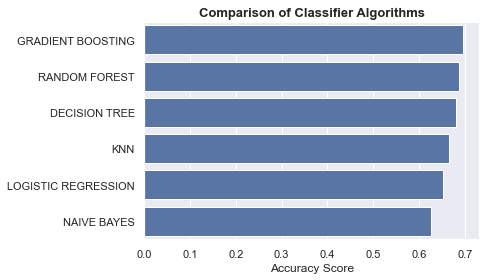

In [96]:
# Visualize accuracy scores for different classifiers
scores = pd.Series(accuracy_scores).sort_values(ascending=False)
sns.barplot(x=scores, y=scores.index, color=c[0])
plt.xlabel('Accuracy Score')
plt.title('Comparison of Classifier Algorithms', fontsize=13, weight='bold');

Comparing the classification reports for the different algorithms shows that with accuracy scores between 0.624 and 0.692, the performance results for all six classifiers are relatively close to each other. The best performing algorithms for this tasks are all models based on Decision Trees, with ensemble methods like Gradient Boosting and Random Forest delivering only slightly better scores than a basic decision tree. The pay-off for these slightly better results is a significantly longer run time for training the model with both ensemble methods. For this rather managable data set, however, this aspect doesn't carry much weight, so I will use the **best-performing Gradient Boosting classifier** for deploying the model later on.

In [97]:
# Load trained gradient boosting classifier
filepath = 'data/gradient_boosting.pkl'
with open(filepath, 'rb') as file:
    clf = pickle.load(file)

Before implementing the model, we can also have a look on importance of certain input features for the model, using a model inspection technique called permutation_importance, which calculates the decrease in model score when a single feature value is randomly shuffled:

In [98]:
from sklearn.inspection import permutation_importance

# Calculate feature weights
result = permutation_importance(clf, X_train, y_train, n_repeats=10)
feature_weights = pd.Series(result.importances_mean, index=df.columns[1:].str.replace('_', ' ').str.capitalize()
                           ).sort_values(ascending=False)

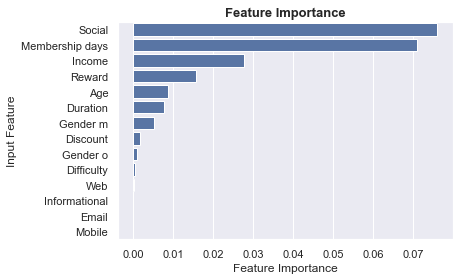

In [99]:
# Visualize feature importance
sns.barplot(x=feature_weights, y=feature_weights.index, color=c[0])
plt.title('Feature Importance', fontsize=13, weight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Input Feature');

The plot reveals that whether an offer was distributed via social media and rewards programme membership time are by far the two most important single input features for the model, which is in accordance with the correlations between input features and offer response as depicted above. Other important features for the model are income and age on the customer side as well as reward and duration on the offer side.

<a href='#contents'>(Table of Contents)</a>
<a id='deployment'></a>
# 5. Deployment

When building a model we should always keep the **practical application** in mind. How could the marketing team at Starbucks profit from this model?  

One possible application would be to use the model to **output the success probabilities** for all different offers for a given list of customer IDs. In the example given below, all promotional offers with a success probability above a defined treshold are marked green and the offer with the highest success probability for each customer is highlighted:

In [100]:
# Load trained gradient boosting classifier
filepath = 'data/gradient_boosting.pkl'
with open(filepath, 'rb') as file:
    clf = pickle.load(file)

In [101]:
def color_by_treshold(val, treshold=0.5):
    '''
    Takes a value and a treshhold and returns a string with the css property 
    'color: green' for all values greater or equal the treshhold, else red.
    '''
    color = 'green' if val >= treshold else 'red'
    return f'color: {color}'

def predict_success_probs(customer_id, clf=clf, portfolio=portfolio, profile=profile):
    '''
    Predicts the probabilities of success for the different offers types for a given customer ID.
    
    INPUT:
    customer_id (str) : ID of a customer contained in the portfolio data frame
    clf (trained classifier) : the trained classification model for making predictions
    portfolio (data frame) : promotional offer portfolio as defined above
    profile (data frame) : demographic customer data
    
    OUTPUT:
    success_probs (list) : list of success probabilities
    '''
    
    success_probs = []
    # Get demographic features
    demographic_data = profile[profile.id == customer_id].drop(columns=['gender', 'id']
                                                              ).values[0]
    # Loop through offers in portfolio
    for row in portfolio.drop(columns=['id', 'offer_type']).iterrows():
        try:
            # Get offer features
            offer_data = list(row)[1]
            # Combine demographic and offer features
            X = np.append(demographic_data, offer_data).reshape(1, -1)
            # Predict proability of succesful offer
            success_probs.append(clf.predict_proba(X)[0][1])
        except:
            success_probs.append(np.nan)
    
    return success_probs

def get_customer_probs(customers, treshold=0.5, portfolio=portfolio):
    '''
    Returns a styled data frame with the success probabilities for every promotional 
    offer in portfolio for each given customer ID, with all values above a given treshold colored
    green and the offer with the highest probability highlighted.
    
    INPUT:
    customers (list) : list of customer IDs
    treshold (float): treshold for succes probability, must be between 0 and 1
    portfolio (data frame) : promotional offer portfolio as defined above
    
    OUTPUT:
    success_probs_df (data frame) : styled data frame with success probabilities
    '''
    # Get probabilites
    prob_values = list(pd.DataFrame(customers).iloc[:,0].apply(predict_success_probs))
    # Create data frame with offer_ids as columns and customer_ids as rows
    success_probs_df = pd.DataFrame(prob_values, columns=portfolio.id, index=customers)
    # Style data frame
    success_probs_df = success_probs_df.style.highlight_max(axis=1)
    success_probs_df = success_probs_df.applymap(color_by_treshold, treshold=treshold)
    
    return success_probs_df

In [102]:
customers = list(profile.head(5).id)
get_customer_probs(customers, treshold=0.33)

id,bogo_1,bogo_2,info_1,bogo_3,discount_1,discount_2,discount_3,info_2,bogo_4,discount_4,bogo_5
0610b486422d4921ae7d2bf64640c50b,0.581103,0.641957,0.227112,0.235132,0.104203,0.786940,0.815745,0.398087,0.691096,0.218271,0.673102
78afa995795e4d85b5d9ceeca43f5fef,0.579363,0.640313,0.416416,0.414314,0.245243,0.785740,0.815469,0.424408,0.689568,0.410229,0.672698
e2127556f4f64592b11af22de27a7932,0.188915,0.207359,0.202694,0.185362,0.140317,0.352328,0.376249,0.378891,0.257911,0.197099,0.221853
389bc3fa690240e798340f5a15918d5c,0.204861,0.207476,0.220589,0.200740,0.169286,0.363526,0.379114,0.427362,0.263888,0.216186,0.218672
2eeac8d8feae4a8cad5a6af0499a211d,0.286900,0.291796,0.279175,0.258778,0.178981,0.483141,0.491237,0.530512,0.387582,0.270055,0.302740


Because the model takes the offer features from *portfolio* and not the *offer_id* itself as input features, we can use the model also to **predict the success probability of new offers** with different feature values:

In [103]:
# Add new record to portfolio
portfolio.loc[10] = ['bogo_5','bogo', 15, 15, 10, 1, 1, 1, 1, 0, 0]
portfolio.tail()

,id,offer_type,reward,difficulty,duration,email,mobile,social,web,discount,informational
6,discount_3,discount,2,10,10,1,1,1,1,1,0
7,info_2,informational,0,0,3,1,1,1,0,0,1
8,bogo_4,bogo,5,5,5,1,1,1,1,0,0
9,discount_4,discount,2,10,7,1,1,0,1,1,0
10,bogo_5,bogo,15,15,10,1,1,1,1,0,0


In [104]:
get_customer_probs(customers, treshold=0.33)

id,bogo_1,bogo_2,info_1,bogo_3,discount_1,discount_2,discount_3,info_2,bogo_4,discount_4,bogo_5
0610b486422d4921ae7d2bf64640c50b,0.581103,0.641957,0.227112,0.235132,0.104203,0.786940,0.815745,0.398087,0.691096,0.218271,0.673102
78afa995795e4d85b5d9ceeca43f5fef,0.579363,0.640313,0.416416,0.414314,0.245243,0.785740,0.815469,0.424408,0.689568,0.410229,0.672698
e2127556f4f64592b11af22de27a7932,0.188915,0.207359,0.202694,0.185362,0.140317,0.352328,0.376249,0.378891,0.257911,0.197099,0.221853
389bc3fa690240e798340f5a15918d5c,0.204861,0.207476,0.220589,0.200740,0.169286,0.363526,0.379114,0.427362,0.263888,0.216186,0.218672
2eeac8d8feae4a8cad5a6af0499a211d,0.286900,0.291796,0.279175,0.258778,0.178981,0.483141,0.491237,0.530512,0.387582,0.270055,0.302740


The *predict_success_probs* function could also be used to **automate the distribution of only potentially succesful offers to customers**. The highlighting above shows that sending each customer only the offer with the highest individual success probability would drastically limit the variation of offers distributed. A better approach could be to define a certain treshold first and then send out a randomly chosen offer with a success probability above this treshold - or no offer at all if there is no one above the treshold.

In [105]:
def get_random_offer(customer_id, treshold=0.5, portfolio=portfolio):
    '''
    Returns an offer for a give customer randomly choosen from all offers in portfolio
    where the success probability is greater or equal than a given treshold.
    '''
    over_treshold = pd.Series(predict_success_probs(customer_id)) >= treshold
    try:
        offer_index = over_treshold[over_treshold].sample().index[0]
        offer_id = portfolio.iloc[offer_index].id
    except:
        offer_id = 'NO OFFER'
    return offer_id

def distribute_offers(customers, treshold=0.5):
    '''
    Simulates the random distribution of one randomly chosen potentially 
    successful offer each (if there is one) to a list of customers.
    '''
    for customer in customers:
        print(f'Distributing {get_random_offer(customer, treshold=treshold)} to customer ID {customer}.')

In [106]:
distribute_offers(customers, treshold=0.4)

Distributing bogo_4 to customer ID 0610b486422d4921ae7d2bf64640c50b.
Distributing bogo_2 to customer ID 78afa995795e4d85b5d9ceeca43f5fef.
Distributing NO OFFER to customer ID e2127556f4f64592b11af22de27a7932.
Distributing info_2 to customer ID 389bc3fa690240e798340f5a15918d5c.
Distributing info_2 to customer ID 2eeac8d8feae4a8cad5a6af0499a211d.


There are lots of further applications possible, but I think the two examples above already demonstrate the potential practical use of the model.

<a href='#contents'>(Table of Contents)</a>
<a id='conclusion'></a>
# 6. Conclusion

In the post above I described the complete data science process involved in using demographic customer data, meta data on promotional offers, and transaction data records from a 30-day experiment provided by Starbucks to build a machine learning model for  predicting customer response on promotional offers. The post highlights the importance of data understanding and wrangling in this process. The project was succesfully completed by training a supervised classifier using gradient boosting, an ensemble method based on decision trees, which turned out to be the best algorithm for this task and predicts customer response with an accuracy rate of almost 70 %. Given the fact that also one and the same customer will react differently on one and the same offer, this is a quite satisfying result. I also drafted a few possible real-world applications for the model.

## Model Limitations and Possible Improvements
From a **business perspective** there is one major caveat with the rather technical **definition of success** applied here, making it less attractive to actually implement the model: A promotional offer was defined as successful as soon as it was both viewed within its duration and a transaction above the offer's treshold was conducted between the viewing event and the expiry of the offer. Some demographic groups, however, will make purchases even if they don't receive an offer, so in terms of business figures it would not make sense to send them a buy 10 dollars get 2 dollars off offer if they would have spent 10 dollars anyway.  

A more business oriented definition of success would be to define offers as successful only when the amount spent after viewing an offer is greater than the sum of the amount the customer would usually spend during the same period of time and the reward the user got for completing the offer. I actually pursued this approach first, but eventually abandoned it due to two limitations in the experimental design:  

1. As there is **no data provided on what customers usually spent**, we would have to pull these information from the transaction data for the 30-day test period. In this context it is important to take into account only those transactions not influenced by any offers for calculating the usual customer spendings, to avoid circular reasoning. However, the time periods during the test that were not influenced by any offers turned out to be so limited for many customers, that it was impossible to calculate reliable average spendings.  
2. Even if we had reliable average purchase data for all customers, we would still face the problem of **overlapping offer duration intervalls** discussed above, which in this case also concerns offers of different types. As a major proportion of transactions is conducted within the duration of multiple offers, there is no way to unambiguously attribute an increase in spendings to a certain offer viewed. To calculate the monetary effect of distinct offers, it would be much better to implement a different experimental design with non-overlapping duration intervalls.

Apart from these obstacles, one could argue that also a purely monetary business definition of success is problematic, as it could tempt the company to not send any promotional offers to its most loyal patrons, arguing that 'they would make the purchase anyway'. Which in the long run proably is not the best way to promote customer loyalty.